In [792]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

n_detectors = 6
n_radii = 4
n_angles = 8
number_of_features = n_detectors*n_radii*n_angles
input_data = []
with open('data/PD034_rings_20_22_25_33.dat', 'r') as inpf: 
    l = inpf.readline()
    print(l)
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        # for i in range(6):
            # for digit in s[i + 1]:
                # features.append(float(digit))
        for digit in s[1:]:
            features.append(float(digit))
        input_data.append([b, features])
    # print(len(input_data))
    
    np.random.shuffle(input_data)
    input_sorted = sorted(input_data, key=lambda x: (x[0]))
    # print(input_data)
    
    features = np.zeros((len(input_data), number_of_features))
    labels = np.zeros((len(input_data), 1))
    incr = 0
    for elem in input_data:
        labels[incr] = np.array(elem[0])
        features[incr] = np.array(elem[1])
        incr += 1
    
    # print(input_sorted[:5])
    # print(input_data[:5])
print(features.shape)

b 8 times 4 radii

(22000, 192)


In [793]:
# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    
    # define borders of segments
    for i in range(groups):   
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=np.int)
    incr = 0
    
    # iterate over all (not sorted) labels and encode them
    for elem in labels:   
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


number_of_groups = 4


# labels_encoded_list = []
# maximum_b = np.max(labels)
# for label in labels:
#     labels_encoded_list.append(encode_equi_segment(label[0], maximum_b, number_of_groups))
# labels_encoded = np.array(labels_encoded_list)
# train_labels = torch.flatten(torch.tensor(labels_encoded[:size_of_training_set]))
# test_labels = torch.flatten(torch.tensor(labels_encoded[size_of_training_set:]))


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32)

print(labels[:10])
labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print(labels_encoded_equisized[:10])
train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))




print('Set shape: ' + str(features.shape))
print('Train features shape: ' + str(train_features.shape))
print('Train labels shape: ' + str(train_labels.shape))
print('Test features shape: ' + str(test_features.shape))
print('Test labels shape: ' + str(test_labels.shape))

[[ 1.451]
 [ 9.337]
 [ 8.437]
 [ 9.912]
 [ 6.039]
 [ 3.662]
 [ 3.347]
 [ 4.685]
 [12.092]
 [ 4.697]]
Length of segment: 5500
Encoded into intervals: [(0, 6.974), (6.974, 9.814), (9.814, 12.043), (12.043, 16.347)]
[[0]
 [1]
 [1]
 [2]
 [0]
 [0]
 [0]
 [0]
 [3]
 [0]]
Set shape: (22000, 192)
Train features shape: torch.Size([17600, 192])
Train labels shape: torch.Size([17600])
Test features shape: torch.Size([4400, 192])
Test labels shape: torch.Size([4400])


In [794]:
# Linear Fully connected network. 
# Convolutional - three blocks below

def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = 128, out_features = 86)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = 86, out_features = 64)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        self.lin4 = nn.Linear(in_features = 64, out_features = 32)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        self.lin5 = nn.Linear(in_features = 32, out_features = 20)
        nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        self.lin6 = nn.Linear(in_features = 20, out_features = 12)
        nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = 12, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        t = F.relu(self.lin4(t))
        t = F.relu(self.lin5(t))
        t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t

In [795]:
net = Network()
print(net.out.weight)
optimizer = optim.Adam(net.parameters(), lr=0.01)
number_of_epoches = 200
loss_weights = torch.tensor([1.,1.,1.,1.])


total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []

# Learning process
for epoch in range(number_of_epoches):
    predicted = net(train_features)
    loss = F.cross_entropy(predicted, train_labels, loss_weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_correct = get_correct_predictions(predicted, train_labels)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss.item(), total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(loss.item())
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Parameter containing:
tensor([[-0.0130,  0.0076, -0.0324,  0.0135,  0.0309,  0.0326,  0.0079,  0.0288,
         -0.0026, -0.0075,  0.0045, -0.0431],
        [-0.0281, -0.0094, -0.0116, -0.0329, -0.0184,  0.0421, -0.0036, -0.0261,
         -0.0028,  0.0242, -0.0005, -0.0205],
        [ 0.0179, -0.0228,  0.0112, -0.0183,  0.0082,  0.0041,  0.0106, -0.0205,
          0.0182, -0.0060,  0.0068, -0.0098],
        [-0.0212, -0.0260, -0.0060,  0.0091, -0.0097, -0.0128, -0.0092, -0.0092,
          0.0377,  0.0032,  0.0214, -0.0384]], requires_grad=True)
Epoch:    0 |---> loss is 1.3862906694, total correct predictions:  4386, its 24.920%
Epoch:    1 |---> loss is 1.3863915205, total correct predictions:  4386, its 24.920%
Epoch:    2 |---> loss is 1.3863114119, total correct predictions:  4441, its 25.233%
Epoch:    3 |---> loss is 1.3862624168, total correct predictions:  4441, its 25.233%
Epoch:    4 |---> loss is 1.3859528303, total correct predictions:  4441, its 25.233%
Epoch:    5 |---> l

Test accuracy is 59.48%


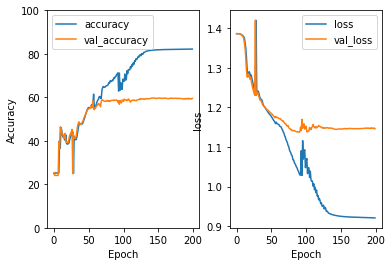

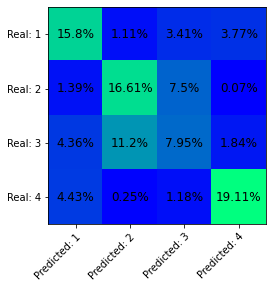

In [796]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions * 100 /test_features.shape[0]))
    
    # Creating of confusion matrix
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    # horizontal axis - predicted, vertical - true
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%', ha="center", va="center", size=12)


[[1.451]
 [9.337]
 [8.437]]
[[0]
 [1]
 [1]]
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [3.3000, 0.0000, 0.0000, 3.3500],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


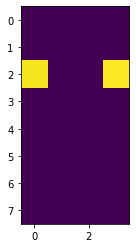

In [797]:
# Convolutional NN
features_reshaped = np.reshape(features, (features.shape[0], n_detectors, n_angles, n_radii))

train_features_c = torch.tensor(features_reshaped[:size_of_training_set], dtype=torch.float32)
test_features_c = torch.tensor(features_reshaped[size_of_training_set:], dtype=torch.float32)


print(labels[:3])
print(labels_encoded_equisized[:3])

# Equisized
train_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))

# print(train_features_conv.shape)
print(train_features_c[0][0])
plt.imshow(train_features_c[0][0])
plt.show()
# print(train_features_c[0][1])
# plt.imshow(train_features_c[0][1])
# plt.show()

In [798]:
'''
batch_size = 500

class DatasetForConv(torch.utils.data.Dataset):
    def __init__(self, labels, features):
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels[idx]
        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}

        return sample


trainDS = DatasetForConv(train_labels_c, train_features_c)
testDS = DatasetForConv(test_labels_c, test_features_c)

train_dataloader = torch.utils.data.DataLoader(trainDS, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testDS, batch_size=len(testDS))


t = True
print(len(train_dataloader))
for elem in train_dataloader:
    if t:
        batch_labels = elem['label']
        batch_features = elem['feature']
        print(batch_labels.shape)
        print(batch_features.shape)
        # print(elem)
    t = False


tf = torch.tensor(np.reshape(features, (features.shape[0], n_detectors, n_angles, n_radii)))
tl = torch.tensor(labels)

testdl = torch.utils.data.DataLoader(DatasetForConv(tl, tf), batch_size=3, shuffle=True)
t = True
for elem in testdl:
    if t:
        print(elem)
    t = False
'''

"\nbatch_size = 500\n\nclass DatasetForConv(torch.utils.data.Dataset):\n    def __init__(self, labels, features):\n        self.labels = labels\n        self.features = features\n\n    def __len__(self):\n        return self.labels.shape[0]\n\n    def __getitem__(self, idx):\n        if torch.is_tensor(idx):\n            idx = idx.tolist()\n\n        label = self.labels[idx]\n        feature = self.features[idx]\n\n        sample = {'label': label, 'feature': feature}\n\n        return sample\n\n\ntrainDS = DatasetForConv(train_labels_c, train_features_c)\ntestDS = DatasetForConv(test_labels_c, test_features_c)\n\ntrain_dataloader = torch.utils.data.DataLoader(trainDS, batch_size=batch_size, shuffle=True)\ntest_dataloader = torch.utils.data.DataLoader(testDS, batch_size=len(testDS))\n\n\nt = True\nprint(len(train_dataloader))\nfor elem in train_dataloader:\n    if t:\n        batch_labels = elem['label']\n        batch_features = elem['feature']\n        print(batch_labels.shape)\n    

In [799]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(4, 2))
        # self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(3, 3))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        # print(self.conv1.weight)
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        
        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=60, out_features=16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        # self.lin3 = nn.Linear(in_features=30, out_features=12)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=30, out_features=16)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=16, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = t
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, n_detectors*2*5*3)))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t



class DatasetForConv(torch.utils.data.Dataset):
    def __init__(self, labels, features):
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels[idx]
        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}

        return sample

In [800]:
batch_size = 800

trainDS = DatasetForConv(train_labels_c, train_features_c)
testDS = DatasetForConv(test_labels_c, test_features_c)
train_dataloader = torch.utils.data.DataLoader(trainDS, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testDS, batch_size=len(testDS))

net_c = NetworkConv()
print(net_c.conv1.weight)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.001, weight_decay=0.0001)
number_of_epoches_c = 100
# Here define weights for loss contribution of segments
loss_weights_c = torch.tensor([1.,1.,1.,1.])

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_c):
    total_correct_c = 0
    t_loss = 0.0
    for batch in train_dataloader:
        batch_labels = batch['label']
        batch_features = batch['feature']


        predicted_c = net_c(batch_features)
        loss_c = F.cross_entropy(predicted_c, batch_labels, loss_weights_c)
        optimizer_c.zero_grad()
        loss_c.backward()
        optimizer_c.step()
        t_loss += (loss_c.item() * batch_size / len(trainDS))
        total_correct_c += get_correct_predictions(predicted_c, batch_labels)
    
    # total_correct_c = get_correct_predictions(predicted_c, train_labels_c)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, t_loss, total_correct_c, total_correct_c*100/train_features_c.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)
        total_accuracy_c.append(total_correct_c*100/train_features_c.shape[0])
        
        test_preds_c = net_c(test_features_c)
        total_val_loss_c.append(F.cross_entropy(test_preds_c, test_labels_c, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds_c, test_labels_c)*100/test_features_c.shape[0])

Parameter containing:
tensor([[[[-8.6076e-04, -3.5095e-02],
          [-1.5519e-03, -2.0823e-02],
          [ 1.2045e-02,  2.3595e-02],
          [-3.5227e-02, -1.9237e-02]],

         [[-1.6419e-02, -2.6600e-02],
          [-5.2252e-02, -2.2885e-03],
          [-2.6791e-02,  2.2036e-02],
          [-1.0109e-02,  8.5584e-03]],

         [[ 1.8117e-02,  4.2394e-03],
          [-3.4982e-03, -1.8870e-02],
          [-1.4894e-02, -1.2371e-02],
          [-2.1290e-03, -8.6542e-03]],

         [[-6.1018e-03, -1.4101e-02],
          [-1.3334e-02,  3.3003e-02],
          [-1.3533e-02,  2.1657e-02],
          [-9.7347e-03, -3.2661e-02]],

         [[-1.1193e-02, -1.2199e-02],
          [-1.5398e-02, -3.3795e-02],
          [-1.2705e-02,  2.8655e-02],
          [-1.1701e-02, -3.7943e-04]],

         [[ 1.8670e-02, -3.0194e-02],
          [-2.3191e-02, -3.2665e-02],
          [ 4.5919e-03,  2.1150e-02],
          [ 2.0002e-03, -8.5953e-03]]],


        [[[ 6.8494e-03, -1.3888e-02],
          [-2.

Test accuracy is 61.25%


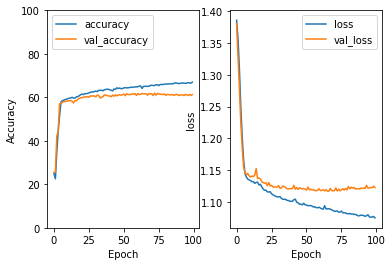

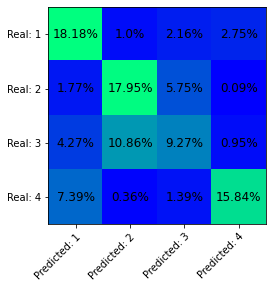

In [801]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features_c)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels_c)
    test_accuracy = test_correct_predictions_c * 100 /test_features_c.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy))
    
    with open('batch_analysis.txt', 'a') as batch_results:
        batch_results.write('| {:7d}     | {:7.2f}  |\n'.format(batch_size, test_accuracy))

    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels_c, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features_c.shape[0],2)) + '%', ha="center", va="center", size=12)

In [802]:
# p1 = net_c.lin1.weight.clone().detach()
p1 = net.lin1.weight.clone().detach()
print(p1.shape)
u, s1, v = torch.svd(p1)
print(s1)
p2 = net_c.lin2.weight.clone().detach()
print(p2.shape)
u, s2, v = torch.svd(p2)
print(s2)

print(net_c.conv1.weight)
print(net_c.out.weight.shape)

torch.Size([128, 192])
tensor([9.5427, 7.6976, 5.3849, 4.7522, 4.5448, 4.3704, 4.2850, 4.2200, 3.9586,
        3.9477, 3.8967, 3.7130, 3.6517, 3.6292, 3.4894, 3.4508, 3.3921, 3.2996,
        3.2349, 3.1726, 3.1498, 3.0711, 3.0460, 2.9438, 2.7881, 2.7378, 2.6572,
        2.6147, 2.5682, 2.5070, 2.4636, 2.3939, 2.3510, 2.2835, 2.2433, 2.1835,
        2.1408, 2.0897, 2.0673, 2.0418, 1.9886, 1.9150, 1.8860, 1.8241, 1.7900,
        1.7319, 1.7138, 1.6924, 1.6422, 1.6215, 1.4997, 1.4730, 1.4522, 1.3718,
        1.3549, 1.2954, 1.2611, 1.2429, 1.2184, 1.1076, 1.0795, 0.9735, 0.9482,
        0.8544, 0.8339, 0.7452, 0.6965, 0.6773, 0.6426, 0.6018, 0.5623, 0.5353,
        0.4908, 0.4495, 0.4357, 0.4027, 0.3939, 0.3464, 0.3004, 0.2831, 0.2812,
        0.2659, 0.2631, 0.2578, 0.2487, 0.2428, 0.2399, 0.2299, 0.2244, 0.2141,
        0.2104, 0.2091, 0.2075, 0.2007, 0.1957, 0.1879, 0.1818, 0.1793, 0.1717,
        0.1688, 0.1642, 0.1604, 0.1530, 0.1506, 0.1419, 0.1396, 0.1389, 0.1368,
        0.1322, 0